In [56]:
import optuna
import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef, accuracy_score,confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


X,y = make_classification(n_samples=2000, n_classes=2,flip_y=0.1) 
##remove 500 samples of class 0 if you maximize accuracy you will se that mcc decreases! 
idx = np.where(y==0)[0][0:500]
X = np.delete(X,idx,axis=0)
y = np.delete(y,idx)


X_train, X_test, y_train, y_test = train_test_split( X,y, test_size=0.33, random_state=0,stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train, test_size=0.33, random_state=0,stratify=y_train)

def objective(trial):

    ##here the non default parameters to test: tria.suggest... means that optuna can change these parameters according to the ranges
    params = dict(
                learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2),
                max_depth= trial.suggest_int("max_depth",5, 15),
                min_child_weight = trial.suggest_int("min_child_weight", 1, 8),
                gamma = trial.suggest_float("gamma", 0, 10),
                subsample = trial.suggest_float("subsample", 0.01,1),
                colsample_bytree = trial.suggest_float("colsample_bytree", 0.01,1),
                alpha = trial.suggest_float("alpha", 0, 10),
                objective= 'binary:logistic', 
                nthread=4, 
                seed=27)
    params['lambda'] = trial.suggest_float("lambda", 0, 10) ## care, lambda can not be placed in the dictionary becasue it is a keyword

    
    dtrain = xgb.DMatrix(X_train,y_train) ## THIS ARE THE GLOBAL NAMES CARE
    dvalid = xgb.DMatrix(X_valid,y_valid)


    bst = xgb.train(params, dtrain,verbose_eval=False, num_boost_round=400,
                    evals = [(dtrain, "train"), (dvalid, "valid")],
                    early_stopping_rounds=100)

    preds = bst.predict(dvalid)
    ##MCC is more solid
    mcc = matthews_corrcoef(y_valid,np.round(preds) )
    
    return mcc



study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40, timeout=600)
##retrain the model with the best parameters
params_final = dict(
            objective= 'binary:logistic', 
            nthread=4, 
            seed=27)
params_final.update(study.best_params)
dtrain = xgb.DMatrix(X_train,y_train)
dvalid = xgb.DMatrix(X_valid,y_valid)   
bst = xgb.train(params_final, dtrain,verbose_eval=False, num_boost_round=400,
                evals = [(dtrain, "train"), (dvalid, "valid")],
                early_stopping_rounds=100,)


[I 2024-02-07 15:41:54,116] A new study created in memory with name: no-name-15856b4f-0922-494b-bffe-6aa5a8b1a949
[I 2024-02-07 15:41:54,414] Trial 0 finished with value: 0.8250111659909584 and parameters: {'learning_rate': 0.10931848666921812, 'max_depth': 7, 'min_child_weight': 1, 'gamma': 1.0874822508422055, 'subsample': 0.22853436663285595, 'colsample_bytree': 0.8800679642371595, 'alpha': 7.857683069294414, 'lambda': 0.9945601089987677}. Best is trial 0 with value: 0.8250111659909584.
[I 2024-02-07 15:41:54,454] Trial 1 finished with value: 0.8479754500993045 and parameters: {'learning_rate': 0.12773722311402283, 'max_depth': 11, 'min_child_weight': 8, 'gamma': 5.8300312437557755, 'subsample': 0.9714643342834144, 'colsample_bytree': 0.4492729210955732, 'alpha': 9.472507025810854, 'lambda': 0.5521132045319688}. Best is trial 1 with value: 0.8479754500993045.
[I 2024-02-07 15:41:54,523] Trial 2 finished with value: 0.8195601516622714 and parameters: {'learning_rate': 0.14523482379164

Text(0, 0.5, 'Feature Importance Score')

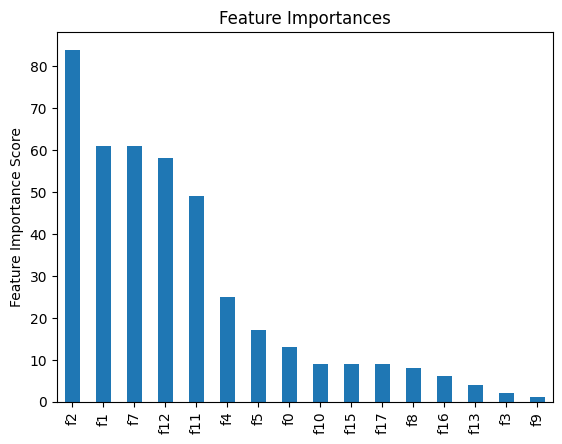

In [57]:
feat_imp = pd.Series(bst.get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [58]:
preds_class_valid = np.round(bst.predict(dvalid))
preds_class_train= np.round(bst.predict(dtrain))
print(confusion_matrix(y_valid,preds_class_valid))
print(matthews_corrcoef(y_valid,preds_class_valid))
print(accuracy_score(y_valid,preds_class_valid))
print('########################################')
print(confusion_matrix(y_train,preds_class_train))
print(matthews_corrcoef(y_train,preds_class_train))
print(accuracy_score(y_train,preds_class_train))

[[106   4]
 [  9 213]]
0.9131472773212349
0.9608433734939759
########################################
[[205  17]
 [ 30 421]]
0.8451352846787803
0.9301634472511144


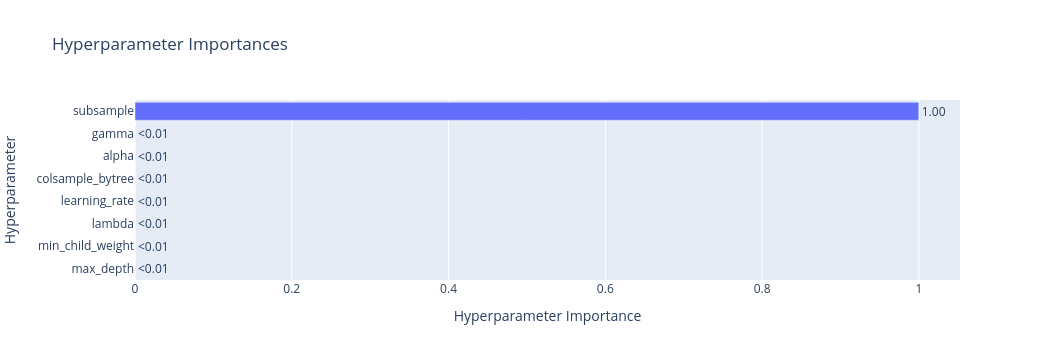

In [28]:
from optuna.visualization import plot_param_importances,plot_edf,plot_optimization_history
#plot_edf(study)
plot_optimization_history(study)

plot_param_importances(study)